In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

#  1. Linear classifier for CIFAR10

In [2]:
#loading the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train:', x_train.shape)
print('y_train:',y_train.shape)
print('x_test:',x_test.shape)
print('y_test:',y_test.shape)

K = len(np.unique(y_train)) #Classes
#limiting the no.of examples
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 #CIFAR10
print('Classes K:',K)

x_train: (50000, 32, 32, 3)
y_train: (50000, 1)
x_test: (10000, 32, 32, 3)
y_test: (10000, 1)
Classes K: 10


- np.unique - Returns the sorted unique elements of an array

In [3]:
#Normalize pixel values ( to have between 0 and 1)
x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image
#converts to catergorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K) 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train: ', x_train.shape)
print('y_train: ',y_train.shape)
print('x_test: ',x_test.shape)
print('y_test: ',y_test.shape)

x_train:  (50000, 3072)
y_train:  (50000, 10)
x_test:  (10000, 3072)
y_test:  (10000, 10)


- np.mean - Compute the arithmetic mean along the specified axis
- tf.keras.utils.to_categorical - converts a class vector (integers) to binary class matrix

In [4]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2     #learning rate,alpha
lr_decay= 0.999
reg = 5e-6      #regularization parameter,lamda

### Definitions

In [5]:
#loss function
def Loss(y_pred,y,w1,w2=0):
    batch_size = y_pred.shape[0]
    loss = (1/batch_size)*(np.square(y-y_pred)).sum() + reg*(np.sum(w1*w1)+np.sum(w2*w2))
    return loss

In [6]:
#accuracy function
def Accuracy(y_pred,y):
    batch_size = y_pred.shape[0]
    K = y_pred.shape[1]
    acc = 1-(1/(batch_size*K))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
    return acc

In [7]:
#linear classifier model
def LinearCls(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    std = 1e-5
    w1 = std*np.random.randn(Din, K)
    b1 = np.zeros(K)

    loss_history = []
    tst_loss_history = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        indices = np.arange(Ntr)
        rng.shuffle(indices)
        x = x_train[indices]
        y = y_train[indices]

        #forward pass
        y_pred = x.dot(w1)+b1
        y_pred_tst = x_test.dot(w1)+b1

        train_loss = Loss(y_pred,y,w1)
        loss_history.append(train_loss)
        test_loss = Loss(y_pred_tst,y_test,w1)
        tst_loss_history.append(test_loss)
        train_acc = Accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc = Accuracy(y_pred_tst,y_test)
        val_acc_history.append(test_acc)

        if t%10==0:
            print('iteration %d / %d: Train loss = %f , Test loss = %f , Train accuracy = %f , Test accuracy = %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        # Backward pass
        dy_pred = (1./batch_size)*2.0*(y_pred-y)  #partial derivative of L w.r.t. y_pred
        dw1 = x.T.dot(dy_pred)+reg*w1
        db1 = dy_pred.sum(axis=0)
        w1-=lr*dw1
        b1-=lr*db1
        lr*=lr_decay
    return w1,b1,loss_history,tst_loss_history,train_acc_history,val_acc_history

- np.random.randn - Return a sample (or samples) from the “standard normal” distribution

In [8]:
w1,b1,loss_history,tst_loss_history,train_acc_history,val_acc_history = LinearCls(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg)

iteration 0 / 300: Train loss = 0.999985 , Test loss = 0.999987 , Train accuracy = 0.686400 , Test accuracy = 0.688520
iteration 10 / 300: Train loss = 0.876637 , Test loss = 0.876238 , Train accuracy = 0.756468 , Test accuracy = 0.758170
iteration 20 / 300: Train loss = 0.842540 , Test loss = 0.842419 , Train accuracy = 0.762618 , Test accuracy = 0.767630
iteration 30 / 300: Train loss = 0.823616 , Test loss = 0.823717 , Train accuracy = 0.766494 , Test accuracy = 0.770630
iteration 40 / 300: Train loss = 0.812389 , Test loss = 0.812708 , Train accuracy = 0.768624 , Test accuracy = 0.771550
iteration 50 / 300: Train loss = 0.805426 , Test loss = 0.805971 , Train accuracy = 0.770334 , Test accuracy = 0.772880
iteration 60 / 300: Train loss = 0.800905 , Test loss = 0.801680 , Train accuracy = 0.771504 , Test accuracy = 0.773440
iteration 70 / 300: Train loss = 0.797821 , Test loss = 0.798825 , Train accuracy = 0.772662 , Test accuracy = 0.773590
iteration 80 / 300: Train loss = 0.795605

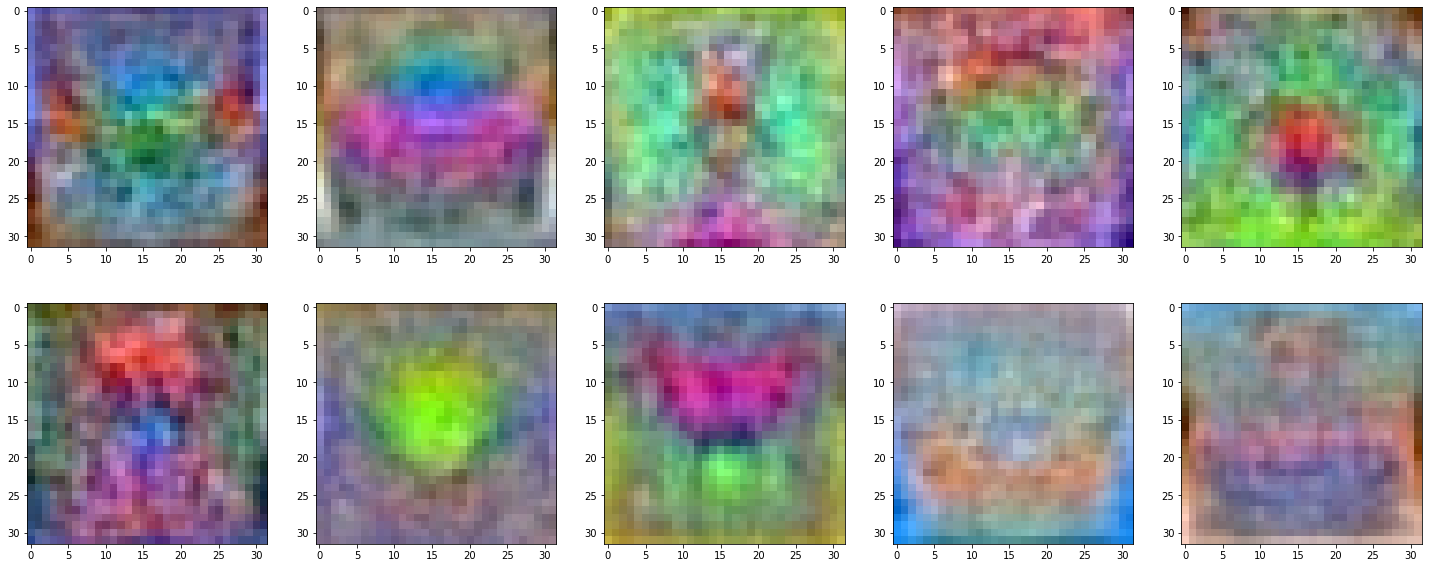

In [9]:
import cv2 as cv
img = []
for i in range(w1.shape[1]):
    im = np.reshape(w1[:,i]*255,(32,32,3))
    im = cv.normalize(im, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)   #normalize the values
    img.append(im)
fig,ax = plt.subplots(2,5,figsize=(25,10))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(img[i*5+j],vmin=0,vmax=255)
plt.show()

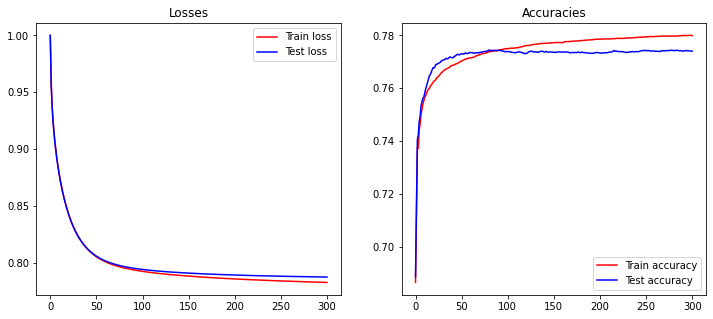

In [10]:
#plotting losses and accuracies
fig, axes  = plt.subplots(1,2, figsize=(12,5))

axes[0].plot(loss_history,color="r")
axes[0].plot(tst_loss_history,color="b")
axes[0].set_title('Losses')
axes[0].legend(['Train loss','Test loss'])

axes[1].plot(train_acc_history,color="r")
axes[1].plot(val_acc_history,color="b")
axes[1].set_title('Accuracies')
axes[1].legend(['Train accuracy','Test accuracy'])

# 2. Two-layer fully connected network

In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train:', x_train.shape)
print('y_train:',y_train.shape)
print('x_test:',x_test.shape)
print('y_test:',y_test.shape)

K = len(np.unique(y_train)) # Classes
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10
print('Classes K:',K)

x_train: (50000, 32, 32, 3)
y_train: (50000, 1)
x_test: (10000, 32, 32, 3)
y_test: (10000, 1)
Classes K: 10


In [12]:
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

y_train = tf.keras.utils.to_categorical(y_train, num_classes=K) 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train: ', x_train.shape)
print('y_train: ',y_train.shape)
print('x_test: ',x_test.shape)
print('y_test: ',y_test.shape)

x_train:  (50000, 3072)
y_train:  (50000, 10)
x_test:  (10000, 3072)
y_test:  (10000, 10)


In [28]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2     #learning rate,alpha
lr_decay= 0.999
reg = 5e-6      #regularization parameter,lamda

In [29]:
H = 200
stdN = 1e-6
w1N = stdN*np.random.randn(Din,H)
w2N = stdN*np.random.randn(H,K)
b1N = np.zeros(H)
b2N = np.zeros(K)
print("w1N:",w1N.shape)
print("w2N:",w2N.shape)
print("b1N:",b1N.shape)
print("b2N:",b2N.shape)

w1N: (3072, 200)
w2N: (200, 10)
b1N: (200,)
b2N: (10,)


In [32]:
def TwoLayer(x_train,y_train,x_test,y_test,K,Din,batch_size,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    H = 200
    stdN = 1e-5
    w1N = stdN*np.random.randn(Din,H)
    w2N = stdN*np.random.randn(H,K)
    b1N = np.zeros(H)
    b2N = np.zeros(K)

    loss_historyN = []
    tst_loss_historyN = []
    train_acc_historyN = []
    val_acc_historyN = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        indices = np.random.choice(Ntr,batch_size)
        rng.shuffle(indices)
        x = x_train[indices]
        y = y_train[indices]
   
        #forward pass
        h = 1.0/(1.0 + np.exp(-(x.dot(w1N)+b1N)))
        h_tst = 1.0/(1.0 + np.exp(-(x_test.dot(w1N)+b1N)))
        y_predN = h.dot(w2N)+b2N
        y_pred_tstN = h_tst.dot(w2N)+b2N

        train_lossN = Loss(y_predN,y,w1N,w2N)
        loss_historyN.append(train_lossN)
        test_lossN = Loss(y_pred_tstN,y_test,w1N,w2N)
        tst_loss_historyN.append(test_lossN)
        train_accN = Accuracy(y_predN,y)
        train_acc_historyN.append(train_accN)
        test_accN = Accuracy(y_pred_tstN,y_test)
        val_acc_historyN.append(test_accN)

        if t%10==0:
            print('iteration %d / %d: Train loss = %f , Test loss = %f , Train accuracy = %f , Test accuracy = %f' % (t,iterations,train_lossN,test_lossN,train_accN,test_accN))

        # Backward pass
        dy_predN = (1./batch_size)*2.0*(y_predN-y)  #partial derivative of L w.r.t. y_pred
        dw2N = h.T.dot(dy_predN)+reg*w2N
        db2N = dy_predN.sum(axis=0)
        dh = dy_predN.dot(w2N.T)
        dw1N = x.T.dot(dh*h*(1-h))+reg*w1N
        db1N = (dh*h*(1-h)).sum(axis=0)
        w1N-=lr*dw1N
        b1N-=lr*db1N
        w2N-=lr*dw2N
        b2N-=lr*db2N
        lr*=lr_decay
    return w1N,b1N,w2N,b2N,loss_historyN,tst_loss_historyN,train_acc_historyN,val_acc_historyN

In [36]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2     #learning rate,alpha
lr_decay= 0.999
reg = 5e-6      #regularization parameter,lamda
w1N,b1N,w2N,b2N,loss_historyN,tst_loss_historyN,train_acc_historyN,val_acc_historyN = TwoLayer(x_train,y_train,x_test,y_test,K,Din,batch_size,lr,lr_decay,reg)

iteration 0 / 300: Train loss = 0.999995 , Test loss = 0.999995 , Train accuracy = 0.749686 , Test accuracy = 0.750000
iteration 10 / 300: Train loss = 1.451652 , Test loss = 1.440037 , Train accuracy = 0.731014 , Test accuracy = 0.730000
iteration 20 / 300: Train loss = 0.862076 , Test loss = 0.861897 , Train accuracy = 0.713140 , Test accuracy = 0.716820
iteration 30 / 300: Train loss = 0.844783 , Test loss = 0.843531 , Train accuracy = 0.728510 , Test accuracy = 0.730330
iteration 40 / 300: Train loss = 0.835855 , Test loss = 0.835401 , Train accuracy = 0.731682 , Test accuracy = 0.732330
iteration 50 / 300: Train loss = 0.827688 , Test loss = 0.828758 , Train accuracy = 0.742982 , Test accuracy = 0.743250
iteration 60 / 300: Train loss = 0.830261 , Test loss = 0.832281 , Train accuracy = 0.737506 , Test accuracy = 0.734470
iteration 70 / 300: Train loss = 0.812686 , Test loss = 0.813383 , Train accuracy = 0.749292 , Test accuracy = 0.750910
iteration 80 / 300: Train loss = 0.808081

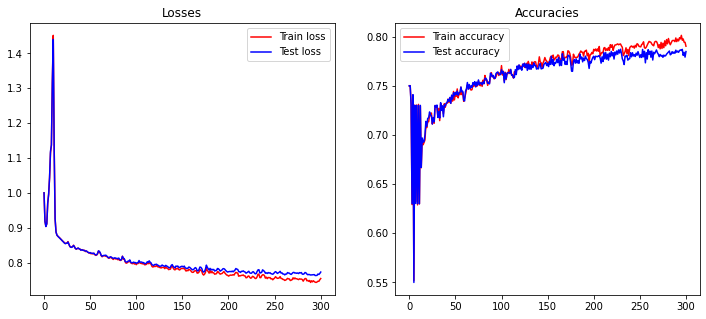

In [37]:
#plotting losses and accuracies
fig, axes  = plt.subplots(1,2, figsize=(12,5))

axes[0].plot(loss_historyN,color="r")
axes[0].plot(tst_loss_historyN,color="b")
axes[0].set_title('Losses')
axes[0].legend(['Train loss','Test loss'])

axes[1].plot(train_acc_historyN,color="r")
axes[1].plot(val_acc_historyN,color="b")
axes[1].set_title('Accuracies')
axes[1].legend(['Train accuracy','Test accuracy'])

# 3. Stochastic gradient descent

In [40]:
batch_size = 500
lr = 1.4e-2     #learning rate,alpha
lr_decay= 0.999
reg = 5e-6      #regularization parameter,lamda
w1N,b1N,w2N,b2N,loss_historyN,tst_loss_historyN,train_acc_historyN,val_acc_historyN = TwoLayer(x_train,y_train,x_test,y_test,K,Din,batch_size,lr,lr_decay,reg)

iteration 0 / 300: Train loss = 0.999993 , Test loss = 0.999993 , Train accuracy = 0.690200 , Test accuracy = 0.690000
iteration 10 / 300: Train loss = 0.892010 , Test loss = 0.889960 , Train accuracy = 0.653000 , Test accuracy = 0.648480
iteration 20 / 300: Train loss = 0.843134 , Test loss = 0.852126 , Train accuracy = 0.745000 , Test accuracy = 0.734170
iteration 30 / 300: Train loss = 0.842698 , Test loss = 0.841499 , Train accuracy = 0.738000 , Test accuracy = 0.740260
iteration 40 / 300: Train loss = 0.828817 , Test loss = 0.830119 , Train accuracy = 0.719200 , Test accuracy = 0.733450
iteration 50 / 300: Train loss = 0.812427 , Test loss = 0.824471 , Train accuracy = 0.741800 , Test accuracy = 0.736930
iteration 60 / 300: Train loss = 0.828829 , Test loss = 0.823116 , Train accuracy = 0.730000 , Test accuracy = 0.739100
iteration 70 / 300: Train loss = 0.821241 , Test loss = 0.816418 , Train accuracy = 0.735000 , Test accuracy = 0.734250
iteration 80 / 300: Train loss = 0.808868

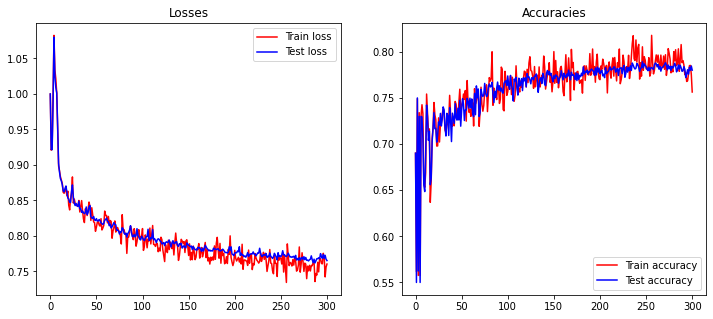

In [54]:
#plotting losses and accuracies
fig, axes  = plt.subplots(1,2, figsize=(12,5))

axes[0].plot(loss_historyN,color="r")
axes[0].plot(tst_loss_historyN,color="b")
axes[0].set_title('Losses')
axes[0].legend(['Train loss','Test loss'])

axes[1].plot(train_acc_historyN,color="r")
axes[1].plot(val_acc_historyN,color="b")
axes[1].set_title('Accuracies')
axes[1].legend(['Train accuracy','Test accuracy'])

# 4. CNN

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)              

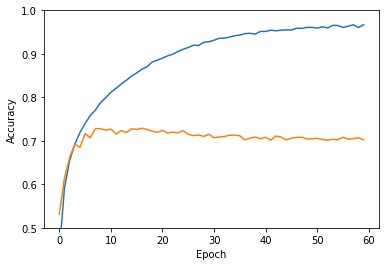

In [60]:
from tensorflow.keras import layers,models

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image
#converts to catergorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K) 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)


model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10))

print(model.summary())

model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["accuracy"])
history=model.fit(x_train,y_train,epochs=60,batch_size=50,validation_data=(x_test,y_test))

plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])

test_loss, test_acc = model.evaluate(x_test,y_test,verbose=2)
print(test_acc)


313/313 - 3s - loss: 2.6068 - accuracy: 0.7020
0.7020000219345093


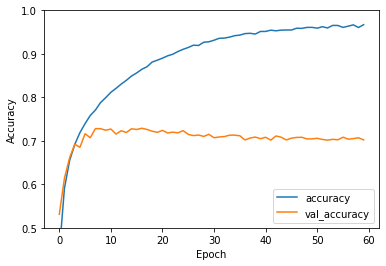

In [61]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,y_test,verbose=2)
print(test_acc)